In [1]:
import torch.utils.data as data
import numpy as np
import glob
import os
import sys
import torch
from scipy import signal
import matplotlib.pyplot as plt

from PIL import Image
if('/opt/ros/kinetic/lib/python2.7/dist-packages' in sys.path):
    sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
import cv2


TACTILE_MAX_MAGNITUDE = np.array([23655, 20662, 14496,  6475, 41133, 64793, 59317, 33177, 19897,
       62084, 49874, 29170, 42944, 14976, 12311, 14331])
POS_MAX_MAGNITUDE = np.array([ 20,  91,  25, 109,  54,  87,  12,  21])
TAC_IMAGE_INDEX = np.array([[12,8,9,10,11],
                          [13,0,1,2,3],
                          [15,4,5,6,7],
                          [14,8,9,10,11]])
POS_IMAGE_INDEX = np.array([[0,6,7,0],
                  [5,1,3,5],
                  [4,0,2,4],
                  [0,6,7,0]])
TACTILE_TIME = 24
UPSAMPLE_FREQ = 18

def video_to_tensor(frames):
    """Convert a ``numpy.ndarray`` to tensor.
    Converts a numpy.ndarray (T x H x W x C)
    to a torch.FloatTensor of shape (C x T x H x W)

    Args:
         pic (numpy.ndarray): Video to be converted to tensor.
    Returns:
         Tensor: Converted video.
    """
    return torch.from_numpy(frames.transpose([3,0,1,2]))

def preprocess_image(cv_frame, size):
    """
    Args:   frame - cv image
            size - tuple of (W x H)
    """

    im = cv2.resize(cv_frame, size) #compress image
    im = np.array(Image.fromarray(cv2.cvtColor(im,cv2.COLOR_BGR2RGB))) #convert to RGB image
    im = im/255 #normalize
    im = (im-0.5)/0.5
    return im

def video_loader(vid_path, frames):
    """
    Args:   vid_path - location of saved video frames
            frames - numpy array of frame number to read
    """
    resize_W = 160
    resize_H = 120
    images = []
    for frame in frames:
        image_name = "frame_{:04}.jpg".format(frame)
        # image_name = "frame_" + str(frame).zfill(4) + ".jpg"
#         image_name = "frame_" + f'{frame:04}' + ".jpg"
        # fixing bug of padding zero_pads.
        if image_name[6]=='-':
            print("wrong zerp padding detected {} , {}".format(image_name, vid_path))
            image_name = image_name.replace('-','0')

        img = cv2.imread(vid_path + image_name)
        ## DEBUG:
        #print(vid_path + image_name)
        #print(img.shape)
        if (img is not None):
            img = preprocess_image(img, (resize_W,resize_H))
            images.append(img)
        else:
            print(vid_path, image_name, img)
            raise ValueError("something went wrong. Expexted {}, {}, {}".format(vid_path, image_name, img))
    return np.array(images)

def tactile_loader(tac_path, frames):
    output =[]
    tac_data = read_tactile_data(tac_path)
    for frame in frames:
        t = tac_data[int(frame),:]
        output.append(t[TAC_IMAGE_INDEX.ravel()].reshape(4,5,1))
    return np.array(output)

def read_tactile_data(tac_path):
    up_samples=TACTILE_TIME*UPSAMPLE_FREQ
    with open(tac_path, 'rb') as f:
        tactile_frame = np.loadtxt(f)
        tactile = tactile_frame.astype('float')
        tactile = signal.resample(tactile,up_samples)
        tactile[np.where(tactile<0.1)] = 0.  # remove all the negative samples with 0
        tactile = tactile/TACTILE_MAX_MAGNITUDE #normalize input in range of 0 to 1.
        tactile = 2*tactile - 1 # normalize in the range of 0 to 1
    return tactile

def pos_loader(pos_path, frames):
    output =[]
    pos = read_pos_data(pos_path)
    for frame in frames:
        p = pos[int(frame),:]
        out = p[POS_IMAGE_INDEX.ravel()].reshape(4,4,1)
        out[0,0] = 0.
        out[3,0] = 0.
        out[0,3] = 0.
        out[3,3] = 0.
        output.append(out)
        # output.append(p[POS_IMAGE_INDEX.ravel()].reshape(4,4,1))
    return np.array(output)

def read_pos_data(pos_path):
    up_samples=TACTILE_TIME*UPSAMPLE_FREQ
    with open(pos_path, 'rb') as f:
        pos_frame = np.loadtxt(f)
        pos = pos_frame.astype('float')
        pos = signal.resample(pos,up_samples)
        pos = pos/POS_MAX_MAGNITUDE #normalize input in range of 0 to 1.
    return pos

def split_frames(start,stop,length):
    """
    To match video frames with tactile,
    Input:  start - starting frame of video
            stop - last frame of video
    output: sequence of frames in batch of length.
    for ex: If length = 18, start = 77 and stop = 300 then
            video is divided into 13 clips and frame number is returned.
    """
    vid_sample = []
    tac_sample = []
    frames = np.arange(start,stop)
    groups = len(frames)//length       #we will get these many clips from given video frames,
    extra_frames = len(frames)%length  #need to fillup missing frames,
    for index, i in enumerate(frames[::length]):
        if(i+length<stop):
            vid_sample.append(np.arange(i,i+length))
            tac_sample.append(np.arange(index*length,index*length+length))
        else:  #now append missing frames
            end_frames = np.arange(i,stop)
            missing_frames = length-end_frames.shape[0]
            end_frames = np.append(end_frames, np.full((missing_frames,),stop))
            vid_sample.append(end_frames)
            tac_sample.append(np.arange(index*length,index*length+length))
    if (vid_sample==[]):
        raise ValueError("Not enough frames in a video")
    if (len(vid_sample) != groups and extra_frames and len(vid_sample) != (groups+1)):
        raise ValueError("something went wrong. Expexted {} splits, but have only {}".format(groups,len(sample)))
    return vid_sample,tac_sample

def get_offset(an_path, lbl_path):
    """
    Get the offset in samples between video and tactile data
    Args:   annotation_path - annotation.txt file containinf video frame alligned with label[0]
            label_path - path of label.txt
    """
    vid_fps = 18
    tac_fps = 16.67
    a = np.loadtxt(an_path)
    l = np.loadtxt(lbl_path)
#     print (annotation, label[0] * (vid_fps/tac_fps), label[2] * (vid_fps/tac_fps), int(annotation - label[0] * (vid_fps/tac_fps)),annotation_path)
    offset = int(a - l[0] * (vid_fps/tac_fps))
    if(offset <= 0):
        # raise ValueError("something wrong{},{}:{},{}".format(a,l[0] * (vid_fps/tac_fps),lbl_path, an_path))
        offset = 1
    return offset

def get_label(pickup, drop, vid_frame, length, actual_label):
    """
    Get the lable for given clip of video
    Args:   pickup - label[0]
            drop - label[2]
            vid_frame - numpy array of video frames
            length - length of clip
            actual_lable - label[3]
    """
    label = None
    label_range = np.arange(pickup, drop)
    #set lable to maximum frames follow
    temp_label = np.zeros(length)
    temp_label[np.in1d(vid_frame,label_range)]=1.0
#     print(temp_label,vid_frame,label_range)
    if(np.where(temp_label==1.0)[0].shape[0] > length//2):
        label = actual_label
    else:
        label = 1
#     print(label)
    return np.array(label,dtype=float)

def get_annotation(path):
    return np.loadtxt(path)


def make_train_dataset(data_path,req_frame_length):
    data = []
    for path in data_path:
        front_vid_path, tac_path, pos_path, label_path, annotation_path = path[0], path[2], path[3], path[-1], path[6]

        # get the offset between video and tactile data
        offset = get_offset(annotation_path, label_path)
        # Read all the video frames
        frames = glob.glob(os.path.join(front_vid_path,'*.jpg'))
        #select video frame from offset to last frame
        video_frames = np.arange(offset, len(frames)+1)
        start,stop = video_frames[0], video_frames[-1]
        if(len(video_frames) >= 430):
            raise ValueError("more image frames = {} than tactile data for video {}".format(video_frames, front_vid_path))
        #collect subsequent frame numbers
        vid_frames, tac_frames = split_frames(start, stop, req_frame_length)
        label = np.loadtxt(label_path)
        annotation = get_annotation(annotation_path)
        for vid_frame, tac_frame in zip(vid_frames, tac_frames):
            pickup, drop = int(label[0]*18/16.67), int(label[2]*18/16.67)
#             print(annotation, pickup,drop,annotation_path)
            sequence_label = get_label(annotation, annotation+(drop-pickup), vid_frame, req_frame_length, label[3])
            data.append((front_vid_path, tac_path, pos_path, label_path, vid_frame, tac_frame, sequence_label))
    return data

def make_test_dataset(data_path,req_frame_length):
    data = []
    for path in data_path:
        front_vid_path, tac_path, pos_path, label_path, annotation_path = path[0], path[2], path[3], path[-1], path[6]

        # get the offset between video and tactile data
        offset = get_offset(annotation_path, label_path)
        # Read all the video frames
        frames = glob.glob(os.path.join(front_vid_path,'*.jpg'))
        #select video frame from offset to last frame
        video_frames = np.arange(offset, len(frames)+1)
        start,stop = video_frames[0], video_frames[-1]
        if(len(video_frames) >= 430):
            raise ValueError("more image frames = {} than tactile data for video {}".format(video_frames, front_vid_path))
        #collect subsequent frame numbers
        vid_frames, tac_frames = split_frames(start, stop, req_frame_length)
        label = np.loadtxt(label_path)
        annotation = get_annotation(annotation_path)
        pickup, drop = int(label[0]*18/16.67), int(label[2]*18/16.67)
        sequence_label = []
        for vid_frame in vid_frames:
#             print(annotation, pickup,drop,annotation_path)
            sequence_label.append(get_label(annotation, annotation+(drop-pickup), vid_frame, req_frame_length, label[3]))
        data.append((front_vid_path, tac_path, pos_path, label_path, vid_frames, tac_frames, sequence_label))
    return data

def get_location(root, split_file):
    data_path = []
    file_path = np.loadtxt(split_file,dtype=str)
    prefix = root.split(file_path[0][:32])[0]
    file_names = ['images/front_rgb/','images/left_rgb/','tactile.txt','pos.txt','label.txt','flow', 'video_grasp_timestamp.txt']
    for i,file in enumerate(file_path):
        front_video_path = prefix + file + file_names[0]
        left_video_path = prefix + file + file_names[1]
        tactile_path = prefix +"/Visual-Tactile_Dataset/tactile_data/"+file.split(file[:32])[1] + file_names[2]
        pos_path = prefix + file + file_names[3]
        label_path = prefix + file + file_names[4]
        front_flow_path = prefix + file + file_names[5] + '/' + 'front_rgb/'
        left_flow_path = prefix + file + file_names[5] + '/' + 'left_rgb/'
        annotation_path = prefix + "/Visual-Tactile_Dataset/dataset_annotations/"+file.split(file[:32])[1] + file_names[6]
        data_path.append((front_video_path, left_video_path, tactile_path, pos_path, \
                       front_flow_path, left_flow_path, annotation_path, label_path))
    return data_path



class VisualTactile(data.Dataset):
    """
    Dataset to load sequence of framses frm the video
    root = directory of ur datasets
    split_file = your test or train split .txt file
    transforms = Transform if you wants to apply to video
    frames_to_load = 18 default, sequence of frames to load
    """

    def __init__(self, root, split_file, transforms=None, frames_to_load = 18):
        self.root = root
        self.split_file = split_file
        self.transforms = transforms
        self.frames_to_load = frames_to_load
        # get path of each file data you would like to process
        self.data_path = get_location(self.root, self.split_file)
        self.num_test_clips = []
        if len(self.data_path) == 0:
            raise (RuntimeError("Found 0 files in subfolders of: " + self.root))

        # get path and frames for training data
        if("train" in split_file):
            self.clip_data = make_train_dataset(self.data_path, self.frames_to_load)
        else:
            self.video_data = make_test_dataset(self.data_path, self.frames_to_load)


    def __getitem__(self,clip_index):
        front_vid_path, tac_path, pos_path, label_path, vid_frames, tac_frames, label = self.clip_data[clip_index]
        # data = self.custom_getitem(front_vid_path, vid_frames, label, tac_path, pos_path, tac_frames)
        # return data, label_path
        clip, tactile, position, label = self.custom_getitem(front_vid_path, vid_frames, label, tac_path, pos_path, tac_frames)
        return clip, tactile, position, label, label_path

    def __len__(self):
        return len(self.clip_data)

    def custom_getitem(self,front_vid_path, vid_frames, label, tac_path=None, pos_path=None, tac_frames=None):
        clip = video_loader(front_vid_path, vid_frames)
        tactile = tactile_loader(tac_path, tac_frames)
        position = pos_loader(pos_path, tac_frames)
        if (self.transforms is not None):
           clip = self.transforms(clip)
        return video_to_tensor(clip),video_to_tensor(tactile),video_to_tensor(position), torch.from_numpy(label)

    def get_video_frames(self, video_index):
        front_vid_path, tac_path, pos_path, label_path, vid_frames, tac_frames, label = self.video_data[video_index]
        data = []
        for vid, tac, lab in zip(vid_frames, tac_frames, label):
            data.append(self.custom_getitem(front_vid_path, vid, lab, tac_path, pos_path, tac))
        return data, label_path

    def get_num_videos(self):
        return len(self.video_data)

    def get_num_clips(self):
        for i in self.video_data:
            self.num_test_clips.append(len(i[4]))
        return sum(self.num_test_clips)
# obj = VisualTactile("../../../t/Visual-Tactile_Dataset/dataset/", "../master_i3d/trainv2.txt")

# Testing dataset code (for training)

In [2]:
path1 = ('../../../../t/Visual-Tactile_Dataset/dataset/Cheez/50_432/top/0/images/front_rgb/', '../../../../t/Visual-Tactile_Dataset/dataset/Cheez/50_432/top/0/images/left_rgb/', '../../../../t/Visual-Tactile_Dataset/tactile_data/Cheez/50_432/top/0/tactile.txt', '../../../../t/Visual-Tactile_Dataset/dataset/Cheez/50_432/top/0/pos.txt', '../../../../t/Visual-Tactile_Dataset/dataset/Cheez/50_432/top/0/flow/front_rgb/', '../../../../t/Visual-Tactile_Dataset/dataset/Cheez/50_432/top/0/flow/left_rgb/', '../../../../t/Visual-Tactile_Dataset/dataset_annotations/Cheez/50_432/top/0/video_grasp_timestamp.txt', '../../../../t/Visual-Tactile_Dataset/dataset/Cheez/50_432/top/0/label.txt')
path2 = ('../../../../t/Visual-Tactile_Dataset/dataset/Cheez/50_432/top/7/images/front_rgb/', '../../../../t/Visual-Tactile_Dataset/dataset/Cheez/50_432/top/7/images/left_rgb/', '../../../../t/Visual-Tactile_Dataset/tactile_data/Cheez/50_432/top/7/tactile.txt', '../../../../t/Visual-Tactile_Dataset/dataset/Cheez/50_432/top/7/pos.txt', '../../../../t/Visual-Tactile_Dataset/dataset/Cheez/50_432/top/7/flow/front_rgb/', '../../../../t/Visual-Tactile_Dataset/dataset/Cheez/50_432/top/7/flow/left_rgb/', '../../../../t/Visual-Tactile_Dataset/dataset_annotations/Cheez/50_432/top/7/video_grasp_timestamp.txt', '../../../../t/Visual-Tactile_Dataset/dataset/Cheez/50_432/top/7/label.txt')
# path1 = ('../../../t/Visual-Tactile_Dataset/dataset/Cheez/50_432/top/0/images/front_rgb/', '../../../t/Visual-Tactile_Dataset/dataset/Cheez/50_432/top/0/images/left_rgb/', '../../../t/Visual-Tactile_Dataset/tactile_data/Cheez/50_432/top/0/tactile.txt', '../../../t/Visual-Tactile_Dataset/dataset/Cheez/50_432/top/0/pos.txt', '../../../t/Visual-Tactile_Dataset/dataset/Cheez/50_432/top/0/flow/front_rgb/', '../../../t/Visual-Tactile_Dataset/dataset/Cheez/50_432/top/0/flow/left_rgb/', '../../../t/Visual-Tactile_Dataset/dataset_annotations/Cheez/50_432/top/0/video_grasp_timestamp.txt', '../../../t/Visual-Tactile_Dataset/dataset/Cheez/50_432/top/0/label.txt')
# path2 = ('../../../t/Visual-Tactile_Dataset/dataset/Cheez/50_432/top/7/images/front_rgb/', '../../../t/Visual-Tactile_Dataset/dataset/Cheez/50_432/top/7/images/left_rgb/', '../../../t/Visual-Tactile_Dataset/tactile_data/Cheez/50_432/top/7/tactile.txt', '../../../t/Visual-Tactile_Dataset/dataset/Cheez/50_432/top/7/pos.txt', '../../../t/Visual-Tactile_Dataset/dataset/Cheez/50_432/top/7/flow/front_rgb/', '../../../t/Visual-Tactile_Dataset/dataset/Cheez/50_432/top/7/flow/left_rgb/', '../../../t/Visual-Tactile_Dataset/dataset_annotations/Cheez/50_432/top/7/video_grasp_timestamp.txt', '../../../t/Visual-Tactile_Dataset/dataset/Cheez/50_432/top/7/label.txt')
path = [path1,path2]
data = make_train_dataset(path, 18)

# Testing dataset code (for testing)

In [ ]:
path1 = ('../../../t/Visual-Tactile_Dataset/dataset/Cheez/50_432/top/0/images/front_rgb/', '../../../t/Visual-Tactile_Dataset/dataset/Cheez/50_432/top/0/images/left_rgb/', '../../../t/Visual-Tactile_Dataset/tactile_data/Cheez/50_432/top/0/tactile.txt', '../../../t/Visual-Tactile_Dataset/dataset/Cheez/50_432/top/0/pos.txt', '../../../t/Visual-Tactile_Dataset/dataset/Cheez/50_432/top/0/flow/front_rgb/', '../../../t/Visual-Tactile_Dataset/dataset/Cheez/50_432/top/0/flow/left_rgb/', '../../../t/Visual-Tactile_Dataset/dataset_annotations/Cheez/50_432/top/0/video_grasp_timestamp.txt', '../../../t/Visual-Tactile_Dataset/dataset/Cheez/50_432/top/0/label.txt')
path2 = ('../../../t/Visual-Tactile_Dataset/dataset/Cheez/50_432/top/7/images/front_rgb/', '../../../t/Visual-Tactile_Dataset/dataset/Cheez/50_432/top/7/images/left_rgb/', '../../../t/Visual-Tactile_Dataset/tactile_data/Cheez/50_432/top/7/tactile.txt', '../../../t/Visual-Tactile_Dataset/dataset/Cheez/50_432/top/7/pos.txt', '../../../t/Visual-Tactile_Dataset/dataset/Cheez/50_432/top/7/flow/front_rgb/', '../../../t/Visual-Tactile_Dataset/dataset/Cheez/50_432/top/7/flow/left_rgb/', '../../../t/Visual-Tactile_Dataset/dataset_annotations/Cheez/50_432/top/7/video_grasp_timestamp.txt', '../../../t/Visual-Tactile_Dataset/dataset/Cheez/50_432/top/7/label.txt')
path = [path1,path2]
data = make_test_dataset(path, 18)

# Testing Videoloader

In [ ]:
front_vid_path, tac_path, pos_path, label_path, vid_frames, tac_frames, label = data[0]
inp = video_loader(front_vid_path, vid_frames)
inp = video_to_tensor(inp)
inp.shape

# Testing Label

In [ ]:
data[0][6]
# video_loader(data[0][0],data[0][4]).shape

# Visualizing tactile Image

In [ ]:
tactile_path = data[10][1]
sensor_frames = data[10][-2]
tac_img = tactile_loader(tactile_path,sensor_frames)
# tac_img[0].shape
fig = plt.figure(figsize=(5,4),frameon=False)

ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)

# ax.imshow(your_image, aspect='normal')
# fig.savefig(fname, dpi)
# ax.imshow(tac_img[0].reshape(4,5),cmap="gray")
# # plt.axis("off")
# plt.savefig("../../../../t/Visual-Tactile_Dataset/tactile_image/t{}.png".format(i))

for i, img in enumerate(tac_img):
    ax.imshow(img.reshape(4,5), cmap="gray")
#     plt.savefig("../../../../t/Visual-Tactile_Dataset/tactile_image/t{}.png".format(i))
#     break
    

# Visaulizing pos image

In [ ]:
pos_path = data[5][2]
sensor_frames = data[5][-2]
pos_img = pos_loader(pos_path,sensor_frames)

fig = plt.figure(figsize=(4,4),frameon=False)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)

for i, img in enumerate(pos_img):
    ax.imshow(img.reshape(4,4), cmap="gray")
    plt.savefig("../../../../t/Visual-Tactile_Dataset/pos_image/p{}.png".format(i))
#     break
    

# Visualizing fused Tactile + Pos image

In [ ]:
TAC_IMAGE_INDEX = np.array([[0,15,0,0,11,0,0,0,0],
                  [0,12,8,0,9,0,10,11,0],
                  [0,13,0,0,1,2,0,3,0],
                  [0,14,4,0,5,0,6,7,4],
                  [9,15,6,0,15,0,9,0,0]])
POS_IMAGE_INDEX = np.array([[0,0,5,4,0,5,2,3,4],
                  [4,0,0,2,0,1,0,0,0],
                  [6,0,0,0,0,0,5,0,1],
                  [7,0,0,4,0,3,0,0,0],
                  [0,0,0,2,0,1,0,3,0]])
MASK = np.array([[0,1,0,0,1,0,0,0,0],
                 [0,1,1,0,1,0,1,1,0],
                 [0,1,1,0,1,1,0,1,0],
                 [0,1,1,0,1,0,1,1,1],
                 [1,1,1,0,1,0,1,0,0]])
MASK = np.logical_not(MASK)

def tp_fused_loader(tac_path, pos_path, frames):
    output = []
    tac_data = read_tactile_data(tac_path)
    pos = read_pos_data(pos_path)
    for frame in frames:
        t = tac_data[int(frame),:]
        p = pos[int(frame),:]
        t = t[TAC_IMAGE_INDEX.ravel()].reshape(5,9)
        p = p[POS_IMAGE_INDEX.ravel()].reshape(5,9)
        t = np.ma.array(t,mask=MASK)
        np.ma.set_fill_value(t, 999999)
        t = t.filled()
        r,c = np.where(t==999999)
        t[r,c] = p[r,c]
        output.append(t.reshape(5,9,1))
    return np.array(output)

In [ ]:
index = 15
tactile_path = data[index][1]
pos_path = data[index][2]
sensor_frames = data[index][-2]
tac_img = tp_fused_loader(tactile_path,pos_path,sensor_frames)
# tac_img[0].shape
fig = plt.figure(figsize=(5,2.8),frameon=False)

ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)

# ax.imshow(your_image, aspect='normal')
# fig.savefig(fname, dpi)
# ax.imshow(tac_img[0].reshape(4,5),cmap="gray")
# # plt.axis("off")
# plt.savefig("../../../../t/Visual-Tactile_Dataset/tactile_image/t{}.png".format(i))

for i, img in enumerate(tac_img):
    ax.imshow(img.reshape(5,9), cmap="gray")
    plt.savefig("../../../../t/Visual-Tactile_Dataset/fused_image/t{}.png".format(i))
#     break
    

# Visualizing 2 channel tactile + joint angle fusion.

(18, 4, 5, 2)

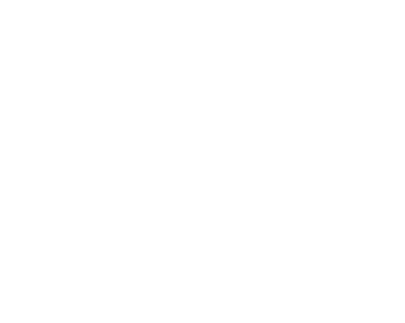

In [27]:
TAC_IMAGE_INDEX = np.array([[14,12,13,14,15],
                            [8,0,1,2,3],
                            [9,4,5,6,7],
                            [15,8,9,10,11]])
POS_IMAGE_INDEX = np.array([[4,1,3,5,0],
                            [5,0,2,4,1],
                            [6,0,7,6,0],
                            [7,1,3,5,0]])

def pos_loader(pos_path, frames):
    output =[]
    pos = read_pos_data(pos_path)
    for frame in frames:
        p = pos[int(frame),:]
        out = p[POS_IMAGE_INDEX.ravel()].reshape(4,5,1)
        out[2,1] = 0.
        out[2,4] = 0.
        output.append(out)
        # output.append(p[POS_IMAGE_INDEX.ravel()].reshape(4,4,1))
    return np.array(output)

index = 15
tactile_path = data[index][1]
pos_path = data[index][2]
sensor_frames = data[index][-2]
tac_img = tactile_loader(tactile_path,sensor_frames)
pos_img = pos_loader(pos_path,sensor_frames)

# tac_img[0].shape
fig = plt.figure(figsize=(5,4),frameon=False)

ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)


tac_img = torch.from_numpy(tac_img)
pos_img = torch.from_numpy(pos_img)

out = torch.cat((tac_img,pos_img),dim=-1) # concatenate w.r.t. last dimension. i.e. over the channel
np.array(out).shape
# for i, img in enumerate(tac_img):
#     ax.imshow(img.reshape(4,5), cmap="gray")
#     plt.savefig("../../../../t/Visual-Tactile_Dataset/2channelFused/tac{}.png".format(i))
    
# for i, img in enumerate(pos_img):
#     ax.imshow(img.reshape(4,5), cmap="gray")
#     plt.savefig("../../../../t/Visual-Tactile_Dataset/2channelFused/pos{}.png".format(i))

# Testing Resnet network

In [ ]:
import resnet
import torch
from torch import nn
import dataset

pretrained_path = "../../../out/resnet/resnet-18-kinetics.pth"
model = resnet.resnet18(sample_size = 112, sample_duration = 18, num_classes = 400, shortcut_type='A')

model = nn.DataParallel(model)
pretrain = torch.load(pretrained_path, map_location="cpu")
model.load_state_dict(pretrain['state_dict'])

x = torch.autograd.Variable(inp)
x = x.unsqueeze(0)
out = model(x.float())

In [ ]:
fc = nn.Linear(1024, 1)
fc(out)

In [ ]:
path1


In [ ]:
TACTILE_MAX_MAGNITUDE = np.array([23655, 20662, 14496,  6475, 41133, 64793, 59317, 33177, 19897,
       62084, 49874, 29170, 42944, 14976, 12311, 14331])
TAC_IMAGE_INDEX = np.array([[12,8,9,10,11],
                          [13,0,1,2,3],
                          [15,4,5,6,7],
                          [14,8,9,10,11]])

from scipy import signal
TACTILE_TIME = 24
UPSAMPLE_FREQ = 18
up_samples=TACTILE_TIME*UPSAMPLE_FREQ


output =[] 
with open(path1[2], 'rb') as f:
    tactile_frame = np.loadtxt(f)
    tactile = tactile_frame.astype('float')
    tactile = signal.resample(tactile,up_samples)
    tactile[np.where(tactile<0.1)] = 0.  # remove all the negative samples with 0
    tactile = tactile/TACTILE_MAX_MAGNITUDE #normalize input in range of 0 to 1.
    for frame in frames:
        t = tactile[frame,:]
        output.append(t[tac_image_index.ravel()].reshape(4,5,1))
output = np.array(output)

In [ ]:
import torch.nn as nn
class tactileNet(nn.Module):
    def __init__(self):
        super(tactileNet,self).__init__()
        self.layer1 = nn.Sequential(nn.Conv3d(1, 16, kernel_size=(3,3,3), padding=2),nn.ReLU())
        self.layer2 = nn.Sequential(nn.Conv3d(16, 32, kernel_size=(3,3,3), padding=1),nn.ReLU(),nn.MaxPool3d(kernel_size=(3,3,3)))
        self.fc1 = nn.Sequential(nn.Linear(768, 64, bias=True), nn.ReLU(inplace=True), nn.Dropout(p = 0.5))
        self.fc2 = nn.Linear(64,1)
    def forward(self, x):
        print(x.shape)
        out = self.layer1(x)
        print(out.shape)
        out = self.layer2(out)
        print(out.shape)
        out = out.view(out.size(0), -1)
        print(out.shape)
        out = self.fc1(out)
        print(out.shape)
        out = self.fc2(out)
        return out

In [ ]:
inp = torch.from_numpy(output.transpose([3,0,1,2]))
inp = inp.unsqueeze(0)
indata = torch.autograd.Variable(inp)
net = tactileNet()
net(indata.float())

In [ ]:
video_to_tensor(output).shape

In [ ]:
frames = data[5][5]

In [ ]:
for frame in frames:
    output.append(tactile[frame,:].reshape(4,4,1))

In [ ]:
np.array(output).shape

In [ ]:
h = np.arange(16,32)
# h = np.arange(0,16)
h

In [ ]:
t = np.zeros((5,9))
p = np.ones((5,9))

In [ ]:
TAC_IMAGE_INDEX = np.array([[0,15,0,0,11,0,0,0,0],
                  [0,12,8,0,9,0,10,11,0],
                  [0,13,0,0,1,2,0,3,0],
                  [0,14,4,0,5,0,6,7,4],
                  [9,15,6,0,15,0,9,0,0]])
POS_IMAGE_INDEX = np.array([[0,0,5,4,0,5,2,3,4],
                  [4,0,0,2,0,1,0,0,0],
                  [6,0,0,0,0,0,5,0,1],
                  [7,0,0,4,0,3,0,0,0],
                  [0,0,0,2,0,1,0,3,0]])
MASK = np.array([[0,1,0,0,1,0,0,0,0],
                 [0,1,1,0,1,0,1,1,0],
                 [0,1,1,0,1,1,0,1,0],
                 [0,1,1,0,1,0,1,1,1],
                 [1,1,1,0,1,0,1,0,0]])
m2 = np.logical_not(MASK)

In [ ]:
h = h[TAC_IMAGE_INDEX.ravel()].reshape(5,9)

In [ ]:
h

In [ ]:
p = np.arange(0,8)
p

In [ ]:
p = p[POS_IMAGE_INDEX.ravel()].reshape(5,9)

In [ ]:
np.ma()

In [ ]:
y = np.ma.array([[1, 2, 3],[56,8,9]], mask = [[0, 1, 0],[1,0,0]])
np.ma.set_fill_value(y, 9999999999)
a = np.copy(y)
y = y.filled()
y

In [ ]:
h = np.ma.array(h,mask=m2)
np.ma.set_fill_value(h, 99)
h = h.filled()
r,c = np.where(h==99)

In [ ]:
h

In [ ]:
h[r,c] = p[r,c]

In [ ]:
h

In [ ]:

TAC_IMAGE_INDEX = np.array([[0,15,0,0,11,0,0,0,0],
                  [0,12,8,0,9,0,10,11,0],
                  [0,13,0,0,1,2,0,3,0],
                  [0,14,4,0,5,0,6,7,4],
                  [9,15,6,0,15,0,9,0,0]])
POS_IMAGE_INDEX = np.array([[0,0,5,4,0,5,2,3,4],
                  [4,0,0,2,0,1,0,0,0],
                  [6,0,0,0,0,0,5,0,1],
                  [7,0,0,4,0,3,0,0,0],
                  [0,0,0,2,0,1,0,3,0]])
MASK = np.array([[0,1,0,0,1,0,0,0,0],
                 [0,1,1,0,1,0,1,1,0],
                 [0,1,1,0,1,1,0,1,0],
                 [0,1,1,0,1,0,1,1,1],
                 [1,1,1,0,1,0,1,0,0]])
m2 = np.logical_not(MASK)

h = np.arange(16,32)
h = h[TAC_IMAGE_INDEX.ravel()].reshape(5,9)
# print(h)
p = np.arange(0,8)
p = p[POS_IMAGE_INDEX.ravel()].reshape(5,9)
# print(p)

h = np.ma.array(h,mask=m2)
np.ma.set_fill_value(h, 999999)
h = h.filled()
r,c = np.where(h==999999)
h[r,c] = p[r,c]
print(h)

In [22]:
import torch.nn as nn
class tactileNet(nn.Module):
    def __init__(self):
        super(tactileNet,self).__init__()
        self.layer1 = nn.Sequential(nn.Conv3d(1, 16, kernel_size=(3,3,3), padding=2),nn.ReLU())
        self.layer2 = nn.Sequential(nn.Conv3d(16, 32, kernel_size=(3,3,3), padding=1),nn.ReLU(),nn.MaxPool3d(kernel_size=(3,3,3)))
        self.fc1 = nn.Sequential(nn.Linear(1152, 64, bias=True), nn.ReLU(inplace=True), nn.Dropout(p = 0.5))
        self.fc2 = nn.Linear(64,1)
    def forward(self, x):
        print(x.shape)
        out = self.layer1(x)
        print(out.shape)
        out = self.layer2(out)
        print(out.shape)
        out = out.view(out.size(0), -1)
        print(out.shape)
        out = self.fc1(out)
        print(out.shape)
        out = self.fc2(out)
        return out


In [26]:
x = torch.rand(45*18).reshape(1,1,18,5,9)
net = tactileNet()
net(x.float())

torch.Size([1, 1, 18, 5, 9])
torch.Size([1, 16, 20, 7, 11])
torch.Size([1, 32, 6, 2, 3])
torch.Size([1, 1152])
torch.Size([1, 64])


tensor([[0.0033]], grad_fn=<AddmmBackward>)